In [1]:

import warnings
warnings.simplefilter('ignore')

import os,glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image,ImageFilter
%matplotlib inline

from scipy.io import loadmat

In [2]:
# Loading Mat file
mat=loadmat('ex4data1.mat')
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
y


In [3]:
# Loading data from mat to Dataframe
m,n=mat['X'].shape

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'][:,i]

# Converting label 10 to label 0
data['y']=mat['y']
data.loc[data['y']==10,'y']=0

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
data.sample(5)

TRAINING DATASET SHAPE : 5000 X 401


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x392,x393,x394,x395,x396,x397,x398,x399,x400,y
565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
3129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [4]:
def displayData(X):
    m,n=X.shape
    width=int(np.sqrt(n))
    height=int(n/width)
    rows=int(np.floor(np.sqrt(m)))
    cols=int(np.ceil(m/rows))
    totalWidth=cols+cols*width
    displayArray=np.zeros((1,totalWidth))
    rowPadding=np.ones((1,totalWidth))
    colPadding=np.ones((height,1))
    index=0
    for i in range(rows):
        row=colPadding*0
        for j in range(cols):
            if index<m:
                x=X[index].reshape((width,height)).T
                index=index+1
            else:
                x=np.zeros((width,height)).T
            row=np.column_stack((row,x))
            if j<cols-1:
                row=np.column_stack((row,colPadding))
        displayArray=np.row_stack((displayArray,row))
        if i<rows-1:
            displayArray=np.row_stack((displayArray,rowPadding))
    displayArray=np.row_stack((displayArray,rowPadding*0))
    plt.imshow(displayArray,cmap='gray')
    plt.axis('off')

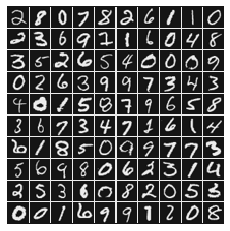

In [5]:
displayData(data.sample(100).iloc[:,:-1].values)

In [6]:
def sigmoid(z):
    sigma=1/(1+np.exp(-z))
    return sigma

In [8]:
def sigmoidGradient(z):
    g=np.multiply(sigmoid(z),(1-sigmoid(z)))
    return g

In [9]:
sigmoidGradient(0)

0.25

In [10]:
def randInitializeWeights(lIn,lOut):
    '''Randomly initialize the weights with a matix of shape lOut X (lIn+1)'''
    epsilonInit=np.sqrt(6)/np.sqrt(lIn+lOut)
    W=np.random.rand(lOut,lIn+1)*2*epsilonInit-epsilonInit
    return W

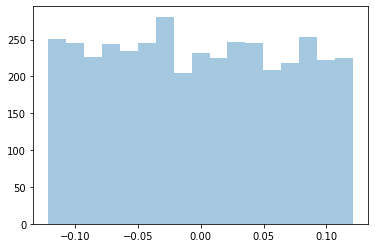

In [11]:
lIn=400
lOut=10

w=randInitializeWeights(lIn,lOut).reshape(-1).tolist()
sns.distplot(w,kde=False);

In [12]:

def computeCost(X,y,params,inputLayerSize,hiddenLayerSize,lmbda):
    '''Computes the cost and the gradient using backpropagation for a 2 layered neural network'''
    m,n=X.shape
    numLabels=y.shape[1]
    # Reshape params into theta1 and theta2 matrices
    theta1=params[:,:hiddenLayerSize*(inputLayerSize+1)].reshape((hiddenLayerSize,inputLayerSize+1))
    theta2=params[:,hiddenLayerSize*(inputLayerSize+1):].reshape((numLabels,hiddenLayerSize+1))
    # Feed Forward Propogation
    a1=np.column_stack((np.ones(m),X))
    z2=np.dot(a1,theta1.T)
    a2=sigmoid(z2)
    a2=np.column_stack((np.ones(shape=(a2.shape[0],1)),a2))
    z3=np.dot(a2,theta2.T)
    a3=sigmoid(z3)
    h=a3
    # Computing cost
    J=(-1/m)*np.sum(np.multiply(y,np.log(h))+np.multiply(1-y,np.log(1-h)))
    # Adding regularization term
    J=J+(lmbda/(2*m))*(np.sum(np.power(theta1[:,1:],2))+np.sum(np.power(theta2[:,1:],2)))
    # Backpropagation
    # Calculating error for hidden and output layer
    delta3=h-y
    delta2=np.multiply(np.dot(delta3,theta2),np.multiply(a2,1-a2))[:,1:]
    # Calculating Gradient
    D2=np.dot(delta3.T,a2)
    D1=np.dot(delta2.T,a1)
    # Adding regularization term
    grad2=(1/m)*D2+(lmbda/m)*np.column_stack((np.zeros((theta2.shape[0],1)),theta2[:,1:]))
    grad1=(1/m)*D1+(lmbda/m)*np.column_stack((np.zeros((theta1.shape[0],1)),theta1[:,1:]))
    # Unroll gradients into one vector
    grad=grad1.reshape((1,-1))
    grad=np.column_stack((grad,grad2.reshape((1,-1))))
    return J,grad

In [13]:
X=mat['X']
# One-hot encoding of target variable
y=pd.get_dummies(mat['y'].reshape(m)).values

# Loading weights
weights=loadmat('./ex4weights.mat')
theta1=weights['Theta1']
theta2=weights['Theta2']
params=theta1.reshape((1,-1))
params=np.column_stack((params,theta2.reshape((1,-1))))

inputLayerSize=400
hiddenLayerSize=25

print(f'X : {X.shape}')
print(f'y : {y.shape}')
print(f'Theta1 : {theta1.shape}')
print(f'Theta2 : {theta2.shape}')

X : (5000, 400)
y : (5000, 10)
Theta1 : (25, 401)
Theta2 : (10, 26)


In [14]:
lmbda=0
J,grad=computeCost(X,y,params,inputLayerSize,hiddenLayerSize,lmbda)
print(f'COST : {J:.4f}')


COST : 0.2876


In [15]:

def computeNumericalGradient(J,theta):
    '''Computes the numerical gradient using two point slope equation'''
    numGrad=np.zeros(theta.shape)
    perturb=np.zeros(theta.shape)
    epsilon=1e-4
    for i in range(theta.size):
        perturb[:,i]=epsilon
        numGrad[:,i]=(J(theta+perturb)-J(theta-perturb))/(2*epsilon)
        perturb[:,i]=0
    return numGrad

In [16]:
def checkNNGradients(lmbda):
    '''Creates a small neural network to check the backpropagation gradients'''
    inputLayerSize=3
    hiddenLayerSize=5
    numLabels=3
    m=50
    # Generating some random test data
    theta1=randInitializeWeights(hiddenLayerSize,inputLayerSize)
    theta2=randInitializeWeights(numLabels,hiddenLayerSize)
    X=randInitializeWeights(inputLayerSize-1,m)
    y=1+np.mod(range(m),numLabels)
    # One-hot encoding target variable
    y=pd.get_dummies(y.reshape(m)).values
    # Unroll into vector
    thetas=theta1.reshape((1,-1))
    thetas=np.column_stack((thetas,theta2.reshape((1,-1))))
    # Gradient from backpropagation
    J,grad=computeCost(X,y,thetas,inputLayerSize,hiddenLayerSize,lmbda)
    # Computing numerical gradient
    def cost(thetas):
        J,grad=computeCost(X,y,thetas,inputLayerSize,hiddenLayerSize,lmbda)
        return J
    numGrad=computeNumericalGradient(cost,thetas)
    # Evaluating the norm of the differences between two solution
    diff=np.linalg.norm(numGrad-grad)/np.linalg.norm(numGrad+grad)
    return grad,numGrad,diff

In [17]:

grad,numGrad,diff=checkNNGradients(0)
print(f'DIFFERENCE : {diff}')
pd.DataFrame(data={'grad (Backprop)':grad.reshape(-1),'grad (numerical)':numGrad.reshape(-1)})

DIFFERENCE : 2.5132716727201516e-10


,grad (Backprop),grad (numerical)
0,0.014160,0.014160
1,0.000827,0.000827
2,0.003570,0.003570
3,-0.000612,-0.000612
4,-0.007682,-0.007682
5,0.002581,0.002581
6,-0.001583,-0.001583
7,0.000625,0.000625
8,0.038622,0.038622
9,0.003937,0.003937


In [18]:
def gradientDescent(X,y,inputLayerSize,hiddenLayerSize,alpha,lmbda,epoch,batchSize):
    m=X.shape[0]
    # One-hot encoding of target variable
    y=pd.get_dummies(y.reshape(-1)).values
    # Initializing parameters randomly
    labels=y.shape[1]
    theta1=randInitializeWeights(inputLayerSize,hiddenLayerSize)
    theta2=randInitializeWeights(hiddenLayerSize,labels)
    # Calculating iterations
    iterations=int(m/batchSize) if (m%batchSize==0) else int(m/batchSize)+1
    jHistory=[]
    for i in range(epoch):
        for j in range(iterations):
            # Setting start and end
            start=j*batchSize
            end=start+batchSize
            end=m if end>m else end
            # Unrolling into one vector
            params=theta1.reshape((1,-1))
            params=np.column_stack((params,theta2.reshape((1,-1))))
            # Computing cost and gradient
            J,grad=computeCost(X[start:end,:],y[start:end,:],params,inputLayerSize,hiddenLayerSize,lmbda)
            # Unrolling vector into grad matrices
            grad1=grad[:,:hiddenLayerSize*(inputLayerSize+1)].reshape((hiddenLayerSize,inputLayerSize+1))
            grad2=grad[:,hiddenLayerSize*(inputLayerSize+1):].reshape((labels,hiddenLayerSize+1))
            # Update rule
            theta1=theta1-alpha*grad1
            theta2=theta2-alpha*grad2
            jHistory.append(J)    
            print(f'EPOCH : {i+1}\tITERATIONS : {j+1}\t\tCOST : {J:.3f}',end='\r')
    df=pd.DataFrame({'Total Iterations':range(epoch*iterations),'Cost Function':jHistory})
    sns.lineplot(data=df,x='Total Iterations',y='Cost Function');
    return theta1,theta2

In [19]:
def predictNN(theta1,theta2,X):
    '''Predict the label of an input given a trained neural network'''
    m,n=X.shape
    # Feed Forward Propogation
    a1=np.column_stack((np.ones(m),X))
    z2=np.dot(a1,theta1.T)
    a2=sigmoid(z2)
    a2=np.column_stack((np.ones(shape=(a2.shape[0],1)),a2))
    z3=np.dot(a2,theta2.T)
    a3=sigmoid(z3)
    h=a3
    labels=h.argmax(axis=1)
    return labels.reshape((m,1))

In [20]:
def calculateAccuracy(h,y):
    '''Calculates the accuray between the target and prediction'''
    m=y.shape[0]
    unique,counts=np.unique(h==y,return_counts=True)
    dic=dict(zip(unique,counts))
    accuracy=(dic[True]/m)*100
    return accuracy

In [21]:

data=data.sample(frac=1,random_state=43)

limit=4500
xTrain=data.values[:limit,:-1]
yTrain=data['y'].values[:limit].reshape((-1,1))
xTest=data.values[limit:,:-1]
yTest=data['y'].values[limit:].reshape((-1,1))

print(f'TRAIN SET : {xTrain.shape}')
print(f'TEST SET : {xTest.shape}')

TRAIN SET : (4500, 400)
TEST SET : (500, 400)


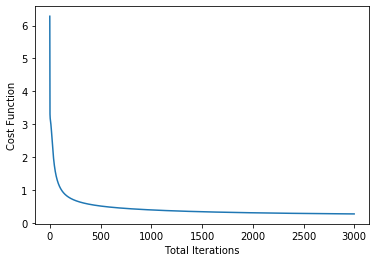

In [22]:
inputLayerSize=400
hiddenLayerSize=25

alpha=1
lmbda=0.5
epoch=3000
batchSize=xTrain.shape[0]

theta1,theta2=gradientDescent(xTrain,yTrain,inputLayerSize,hiddenLayerSize,alpha,lmbda,epoch,batchSize)

In [23]:
h=predictNN(theta1,theta2,xTrain)
accuracy=calculateAccuracy(h,yTrain)
print(f'TRAIN ACCURACY : {accuracy:.3f}%')

TRAIN ACCURACY : 98.711%


In [24]:

h=predictNN(theta1,theta2,xTest)
accuracy=calculateAccuracy(h,yTest)
print(f'TEST ACCURACY : {accuracy:.3f}%')

TEST ACCURACY : 94.400%
